# Hyperparameter Tuning

Grid search and Random search are automated ways of tuning different hyperparameters. Both require a grid to sample from (which hyperparameter-value combinations), a cross-validation scheme, and a scoring function.

## Grid Search
Grid Search exhaustively tries all combinations within the sample space. No sampling methodology is necessary.

Grid Search is computational expensive, but guaranteed to find the best score in the sample space.

## Setup

In [65]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from itertools import product
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score

In [55]:
df = pd.read_csv('diabetes.csv')
df.head()

,age,bmi,systolic_bp,diastolic_bp,cholesterol_level,glucose_level,activity_level,family_history,smoking_status,diet_score,diabetes_risk
0,56,33.4,159,79,205,151,358,1,0,10,1
1,69,27.5,135,104,245,146,219,0,0,9,0
2,46,43.0,132,66,224,145,105,0,0,10,0
3,32,41.0,110,73,292,107,374,0,1,6,0
4,60,16.4,112,68,181,140,69,1,1,7,0


## Train, test, split

In [56]:
X = df.drop('diabetes_risk', axis=1)
y = df['diabetes_risk']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

## Manual Grid Search

In [57]:
def gbm_grid_search(learn_rate, max_depth):
    model = GradientBoostingClassifier(
        learning_rate=learn_rate,
        max_depth=max_depth,
    )
    predictions = model.fit(X_train, y_train).predict(X_test)
    return [learn_rate, max_depth, accuracy_score(y_test, predictions)]

In [58]:
learn_rates = [0.001, 0.01, 0.05]
max_depths = [4,6,8,10]
results_list = []

for learn_rate in learn_rates:
    for max_depth in max_depths:
        results_list.append(gbm_grid_search(learn_rate, max_depth))

results_df = pd.DataFrame(results_list, columns=['learn_rate', 'max_depth', 'accuracy'])

results_df

,learn_rate,max_depth,accuracy
0,0.001,4,0.755
1,0.001,6,0.790
2,0.001,8,0.870
3,0.001,10,0.855
4,0.010,4,0.920
5,0.010,6,0.865
6,0.010,8,0.835
7,0.010,10,0.855
8,0.050,4,0.965
9,0.050,6,0.915


## Grid Search with Scikit Learn

Three steps.
1. Select an algorithm to tune the hyperparameters (sometimes referred to as an estimator)
2. Define hyperparameters to tune
3. Define range of values for hyperparameters
4. Set a cross-validation scheme and scoring function

## Create a GridSearchCV object

In [59]:
# create the grid
param_grid= {'max_depth': [2, 4, 6, 8], 'min_samples_leaf': [1, 2, 4, 6]}

# create a base classifier
rf_class = RandomForestClassifier(criterion='entropy', max_features=None)

grid_rf_class = GridSearchCV(
    estimator=rf_class,
    param_grid=param_grid,
    scoring='accuracy',
    n_jobs=4,
    cv = 10,
    refit=True, # enables direct use of the object as an estimator
    return_train_score=True
)

# fit the estimator to the data
grid_rf_class.fit(X_train, y_train)

# make predictions
predictions = grid_rf_class.predict(X_test)

# calculate accuracy
print(accuracy_score(y_test, predictions))

0.92


## Analyze GridSearchCV output

GridSearchCV properties

Results log:
- cv_results_

Best results:
- best_index_, best_params_, best_score_

Extra information:
- scorer_, n_splits_, refit_time_

### cv_results_

In [60]:
results = grid_rf_class.cv_results_ # A dictionary of results for each model created
results_df = pd.DataFrame(results)

results_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.090573,0.001992,0.003014,0.000098,2,1,"{'max_depth': 2, 'min_samples_leaf': 1}",0.7250,0.8125,0.7375,...,0.801389,0.827778,0.833333,0.840278,0.847222,0.818056,0.843056,0.838889,0.826667,0.015674
1,0.091062,0.001514,0.002937,0.000089,2,2,"{'max_depth': 2, 'min_samples_leaf': 2}",0.6500,0.8125,0.7375,...,0.804167,0.827778,0.809722,0.850000,0.822222,0.840278,0.847222,0.831944,0.823750,0.020112
2,0.089802,0.001916,0.002901,0.000046,2,4,"{'max_depth': 2, 'min_samples_leaf': 4}",0.6375,0.7875,0.7875,...,0.813889,0.825000,0.794444,0.863889,0.818056,0.843056,0.847222,0.838889,0.828472,0.020900
3,0.090881,0.002096,0.002985,0.000083,2,6,"{'max_depth': 2, 'min_samples_leaf': 6}",0.7125,0.8000,0.7875,...,0.829167,0.831944,0.843056,0.831944,0.823611,0.836111,0.825000,0.843056,0.829028,0.010043
4,0.138917,0.001456,0.003154,0.000073,4,1,"{'max_depth': 4, 'min_samples_leaf': 1}",0.8375,0.8500,0.8750,...,0.918056,0.933333,0.926389,0.947222,0.952778,0.941667,0.919444,0.926389,0.934444,0.011798


## Random Search
Random Search randomly selects a subset of combinations within the provided sample space. Uniform is the default sampling methodology, though others can be selected.

Random Search is less computationally expensive, but likely to find a *good* one *faster*.

### Manual Random Search

In [61]:
# set hyperparameter limits
learn_rates_list = np.linspace(0.001, 2, 150)
min_samples_leaf_list = list(range(1,51))

# create a list of combinations
combinations_list = [list(x) for x in product(learn_rates, min_samples_leaf_list)]

# randomly select 100 models
random_combinations_index = np.random.choice(
    range(0,len(combinations_list)), 100,
    replace=False)

selected_combinations = [combinations_list[x] for x in random_combinations_index]
print(selected_combinations)

[[0.001, 11], [0.01, 18], [0.001, 9], [0.05, 4], [0.001, 28], [0.01, 37], [0.01, 34], [0.01, 32], [0.01, 1], [0.01, 42], [0.05, 22], [0.01, 38], [0.05, 35], [0.001, 44], [0.05, 27], [0.01, 14], [0.001, 8], [0.001, 34], [0.001, 30], [0.001, 43], [0.001, 7], [0.01, 26], [0.001, 35], [0.05, 6], [0.01, 40], [0.05, 20], [0.001, 18], [0.05, 11], [0.05, 2], [0.05, 26], [0.001, 3], [0.001, 16], [0.01, 6], [0.001, 48], [0.05, 37], [0.05, 31], [0.001, 23], [0.05, 45], [0.05, 30], [0.001, 37], [0.001, 4], [0.05, 40], [0.01, 8], [0.001, 25], [0.001, 19], [0.001, 12], [0.01, 20], [0.01, 22], [0.01, 11], [0.05, 16], [0.01, 44], [0.001, 29], [0.01, 47], [0.001, 6], [0.05, 18], [0.05, 32], [0.05, 10], [0.001, 22], [0.01, 24], [0.05, 48], [0.001, 24], [0.05, 33], [0.01, 5], [0.01, 48], [0.05, 34], [0.01, 4], [0.05, 42], [0.01, 7], [0.05, 39], [0.01, 30], [0.001, 5], [0.05, 38], [0.001, 46], [0.01, 13], [0.05, 28], [0.01, 10], [0.001, 40], [0.01, 27], [0.05, 15], [0.01, 33], [0.05, 3], [0.01, 15], [0.00

### Random Search with Scikit Learn

When working with RandomSearchCV, there is only one extra step compared to GridSearchCV: decide the number of samples to take.

In [64]:
random_rf_class = RandomizedSearchCV(
    estimator=rf_class,
    param_distributions=param_grid,
    n_iter=50,
    scoring='accuracy',
    n_jobs=4,
    refit=True,
    return_train_score=True,
    random_state=11,
    cv=5
)

random_rf_class.fit(X_train, y_train)
predictions = random_rf_class.predict(X_test)
print(accuracy_score(y_test, predictions))

0.915


Key differences between GridSearchCV and RandomizedSearchCV:
- n_iter takes the number of samples for the random search to take from the grid
- param_distributions allows for the optional ability to set a distribution for sampling.

## Visualize results

In [67]:
random_rf_class.cv_results_

{'mean_fit_time': array([0.170012  , 0.0870728 , 0.13162503, 0.1520143 , 0.15058522,
        0.1326386 , 0.12972345, 0.15809202, 0.08695531, 0.16288252]),
 'std_fit_time': array([0.00661133, 0.00237954, 0.00258623, 0.00138105, 0.00282219,
        0.00271411, 0.00062463, 0.00246177, 0.00203509, 0.00285844]),
 'mean_score_time': array([0.00367298, 0.00317125, 0.0033083 , 0.00363154, 0.00352759,
        0.00340452, 0.00344644, 0.00365195, 0.00311875, 0.00364738]),
 'std_score_time': array([7.65980085e-05, 1.82871582e-04, 1.11575514e-04, 1.95951030e-04,
        1.11204457e-04, 5.66777881e-05, 9.37876508e-05, 1.04651863e-04,
        9.63806922e-05, 1.10323817e-04]),
 'param_min_samples_leaf': masked_array(data=[1, 6, 4, 4, 6, 1, 2, 4, 4, 2],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value=999999),
 'param_max_depth': masked_array(data=[6, 2, 4, 6, 8, 4, 4, 8, 2, 8],
              mask=[False, False, False, Fal

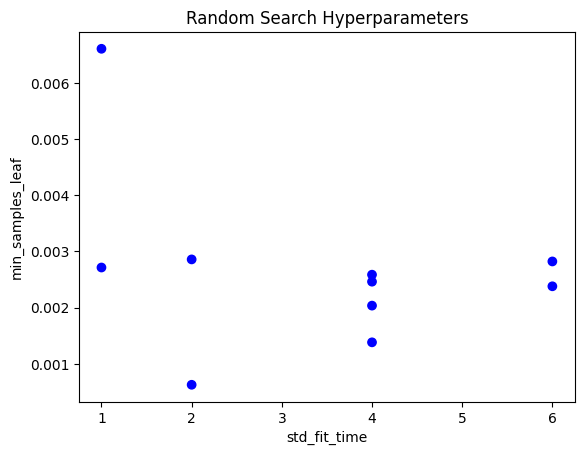

In [69]:
rand_x = list(random_rf_class.cv_results_['std_fit_time'])
rand_y = list(random_rf_class.cv_results_['param_min_samples_leaf'])

x_lims = [np.min(learn_rates_list), np.max(learn_rates_list)]
y_lims = [np.min(min_samples_leaf_list), np.max(min_samples_leaf_list)]

plt.scatter(rand_y, rand_x, c=['blue']*10)
plt.gca().set(xlabel='std_fit_time', ylabel='min_samples_leaf', title='Random Search Hyperparameters')
plt.show()


## Considerations
Random search may be more valuable than Grid Search if:
- There is a large quantity of data
- There are a large number of hyperparameter-value combinations
- There is limited computational resources